In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
import time
import random
from tqdm import tqdm_notebook

# Fastai
from fastai import *
from fastai.tabular import *

In [17]:
PATH = Path('/storage/santander_comp/')

In [18]:
train = pd.read_csv(PATH/'train.csv', engine = 'python')
test = pd.read_csv(PATH/'test.csv', engine = 'python')

In [22]:
len(train)

200000

In [24]:
len(train.loc[train['target']==0])

179902

In [25]:
# Features
# get the features list
%time
features = [feature for feature in train.columns if feature != 'target']
len(features)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


201

In [26]:
%time
train.shape, test.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


((200000, 202), (200000, 201))

In [27]:
len(features)

201

In [28]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

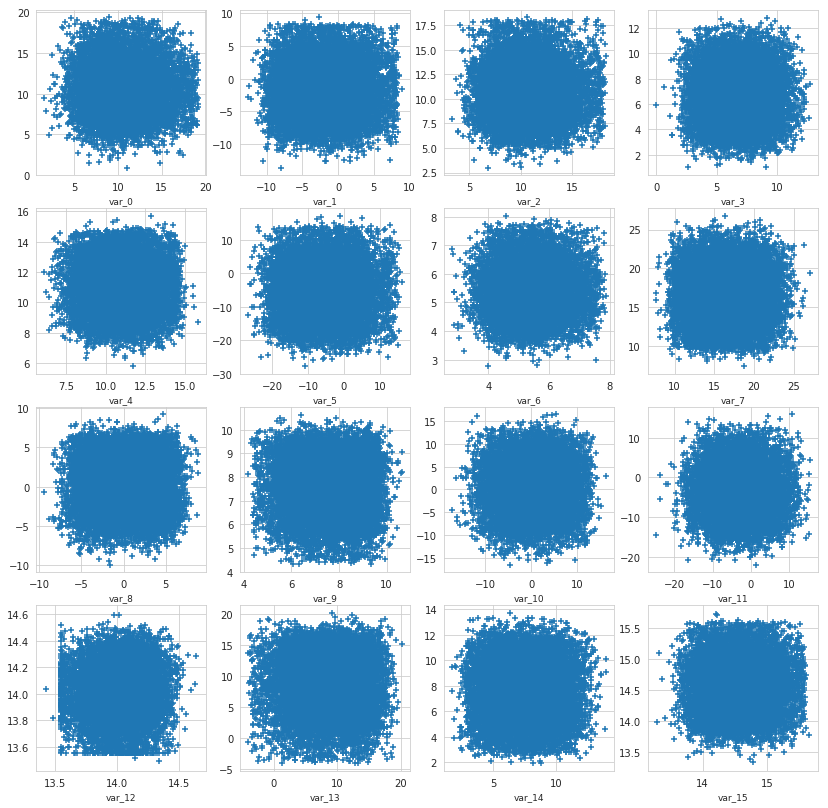

In [7]:
features = [f'var_{num}' for num in range(0,16)]
plot_feature_scatter(train[::20],test[::20], features)

<Figure size 432x288 with 0 Axes>

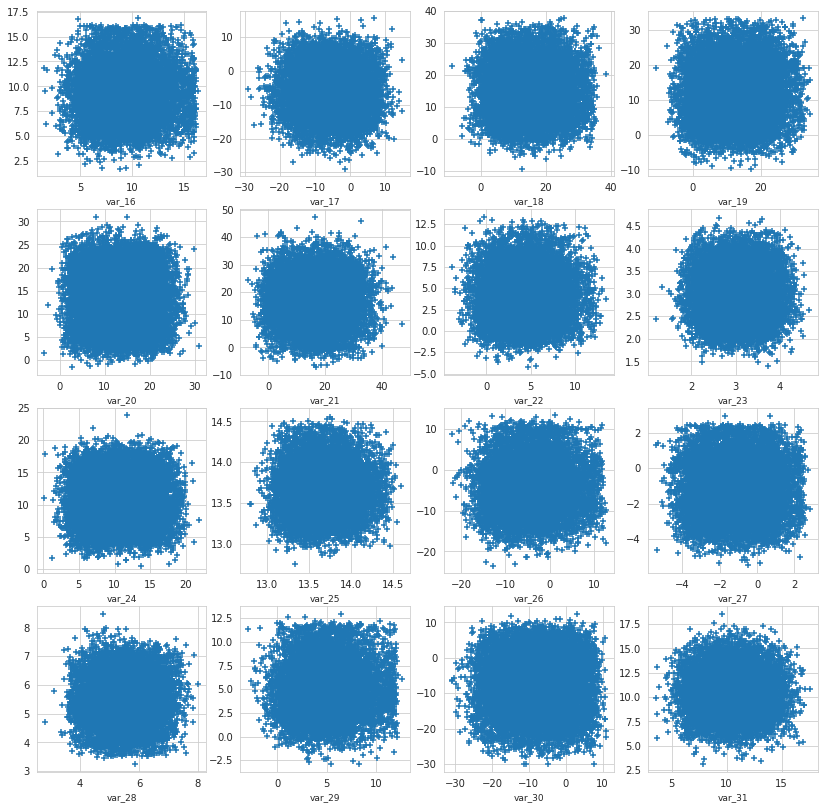

In [8]:
features = [f'var_{num}' for num in range(16,32)]
plot_feature_scatter(train[::20],test[::20], features)

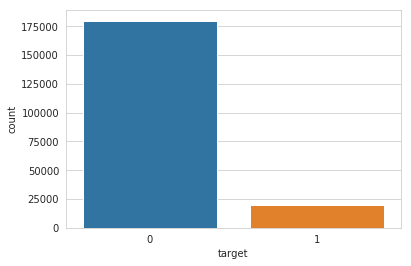

In [9]:
sns.countplot(train.target)

In [29]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [31]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]

In [32]:
features

array(['var_0', 'var_1', 'var_2', 'var_3', ..., 'var_96', 'var_97', 'var_98', 'var_99'], dtype=object)

<Figure size 432x288 with 0 Axes>

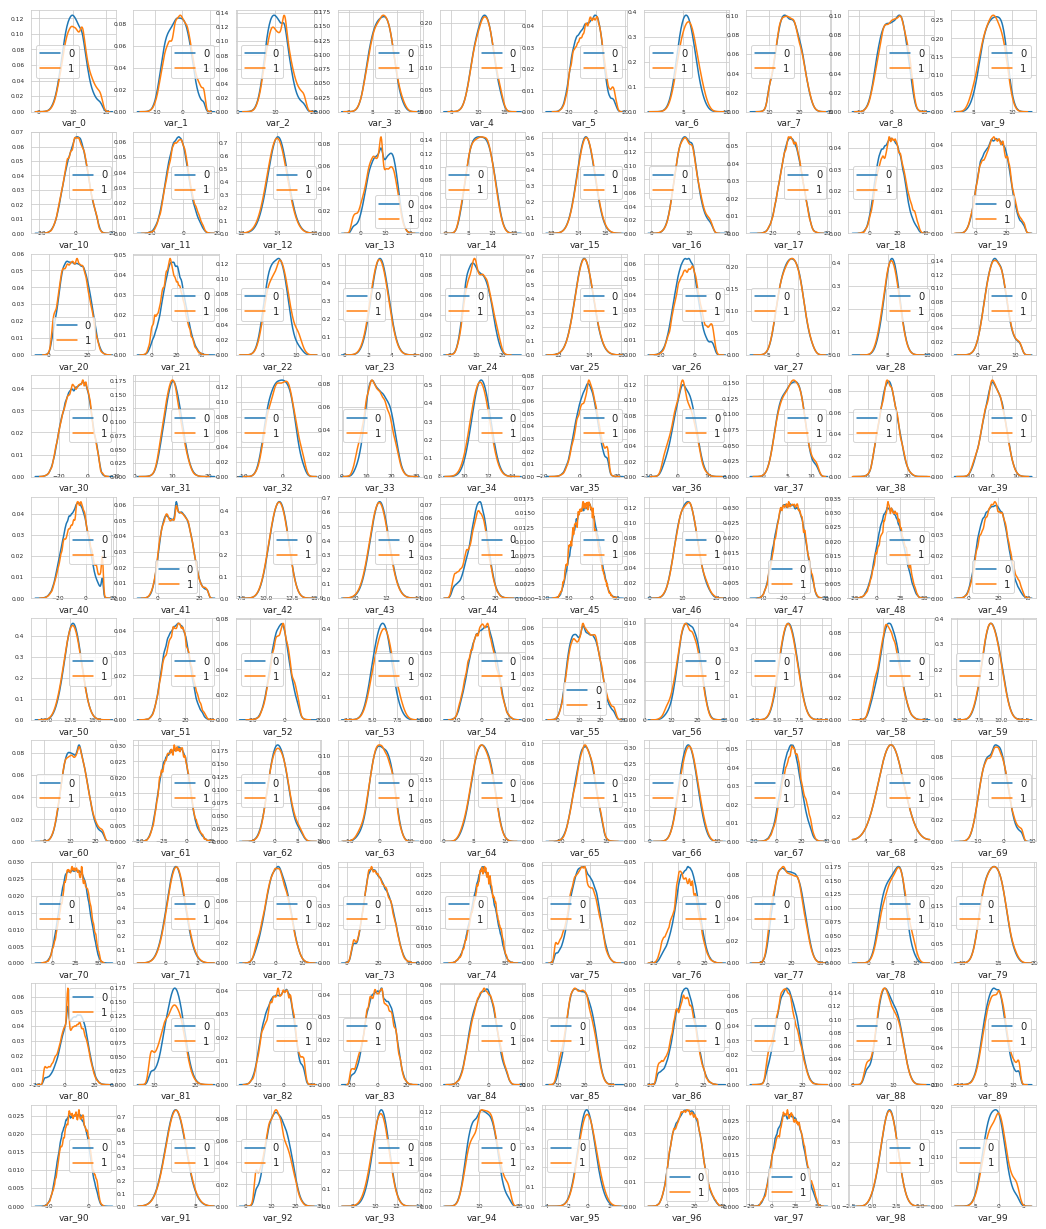

In [33]:
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

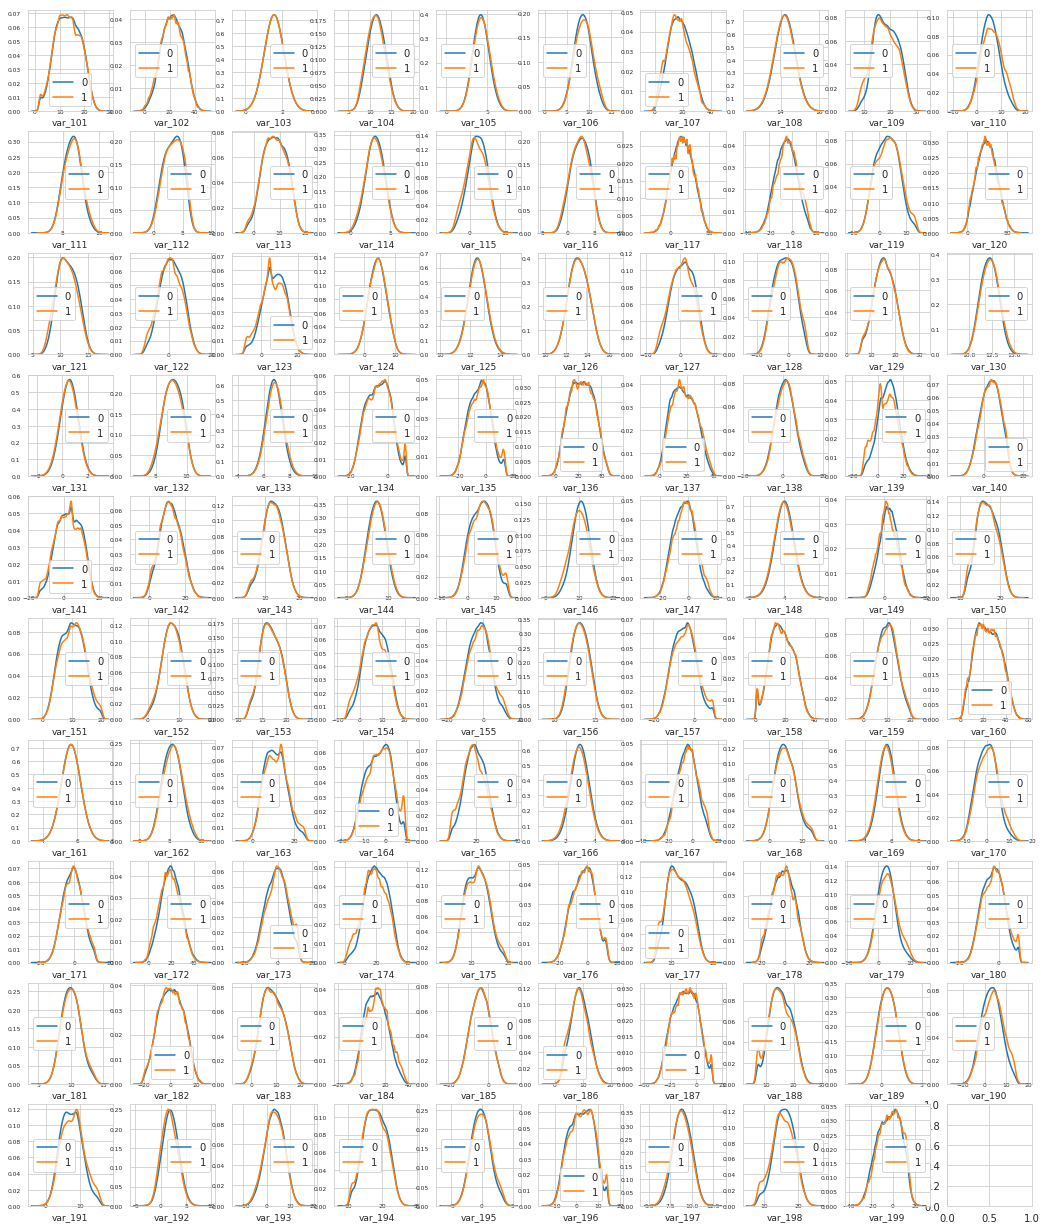

In [12]:
features = train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

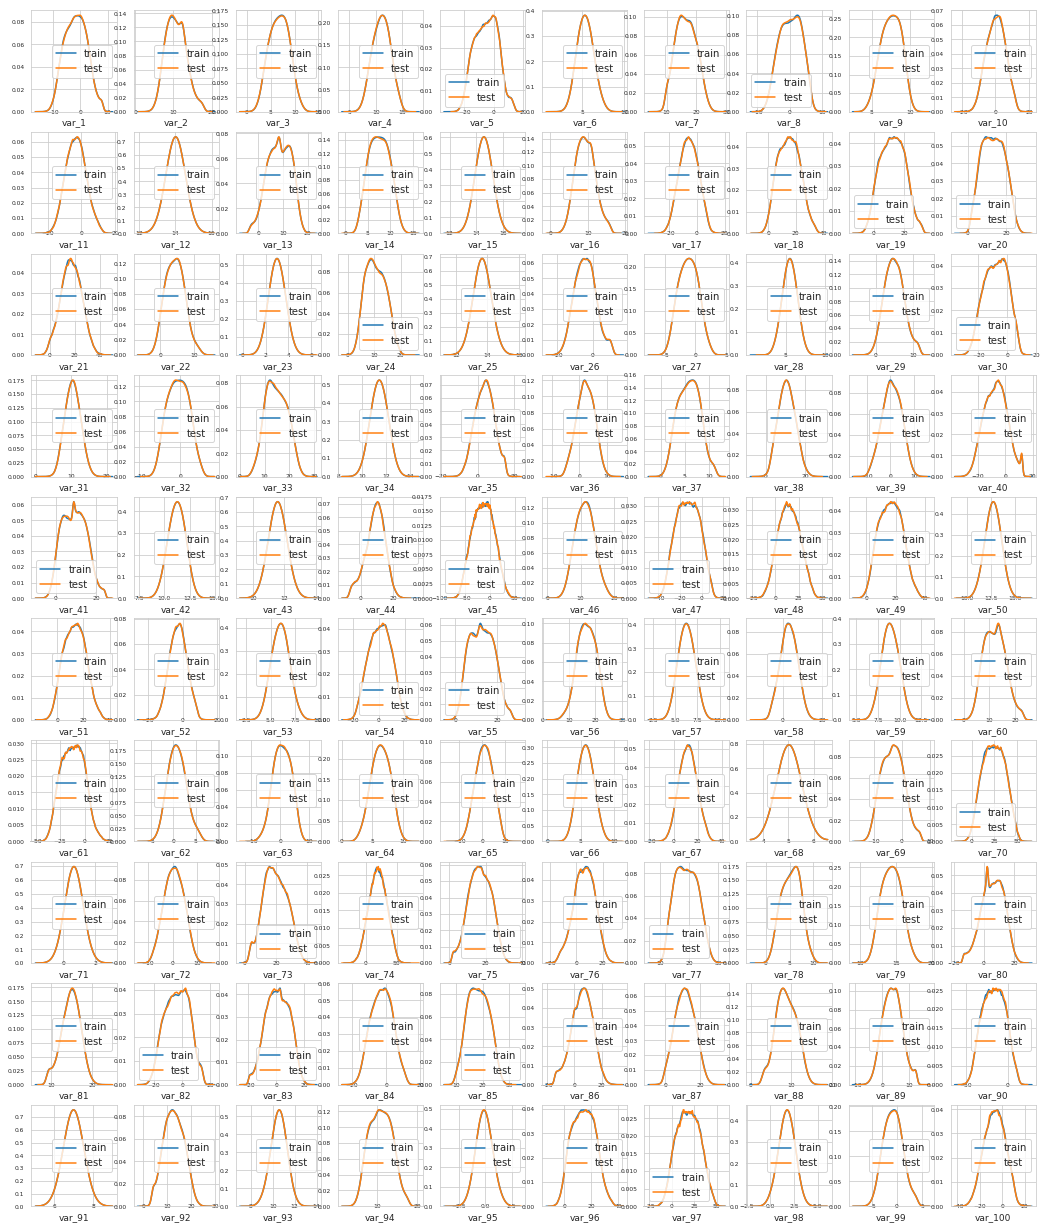

In [13]:
features = train.columns.values[2:102]
plot_feature_distribution(train, test, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

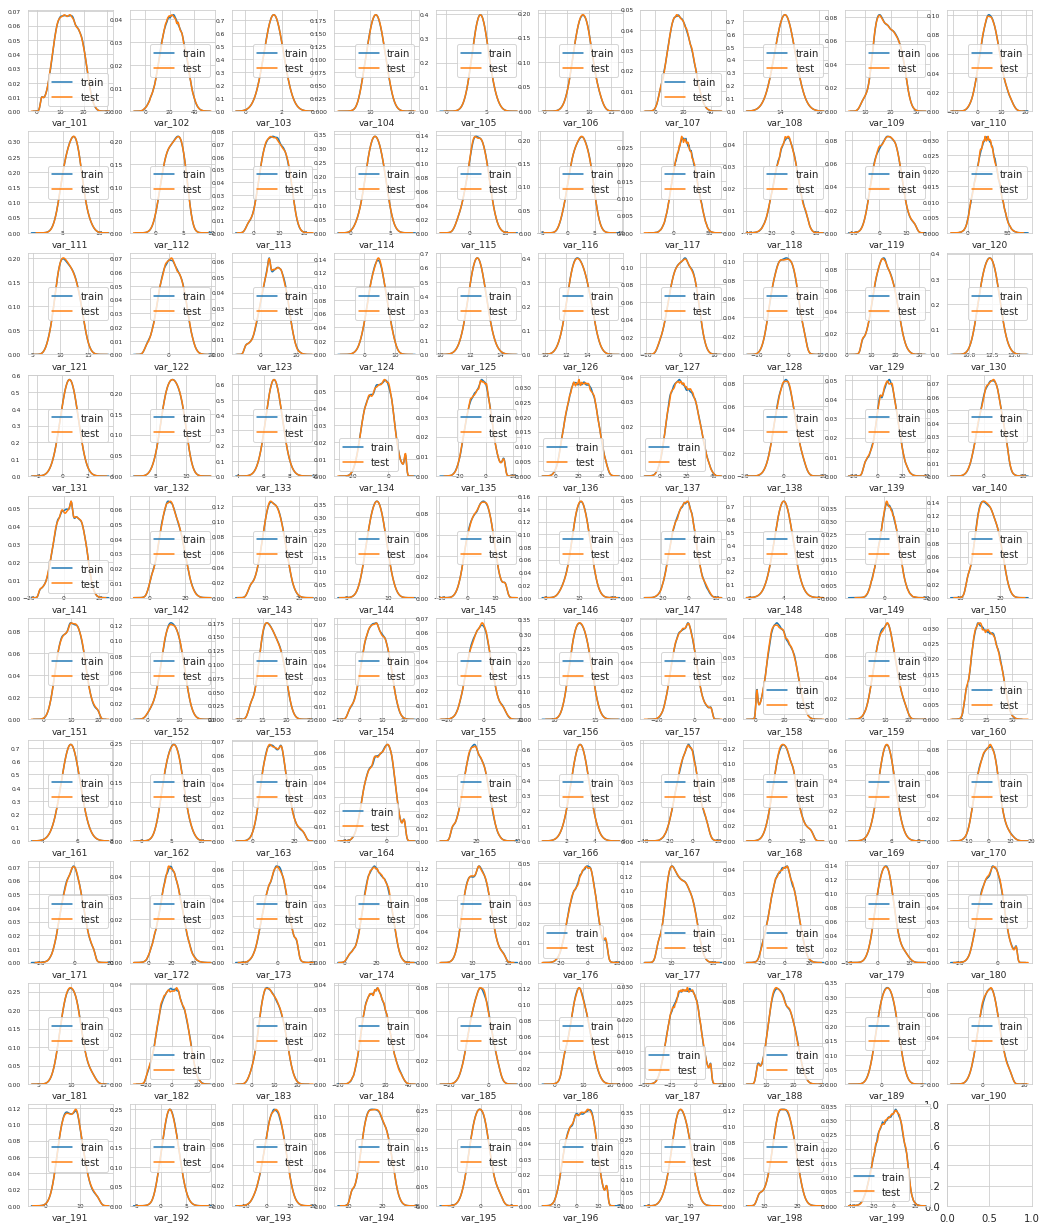

In [14]:
features = train.columns.values[102:202]
plot_feature_distribution(train, test, 'train', 'test', features)

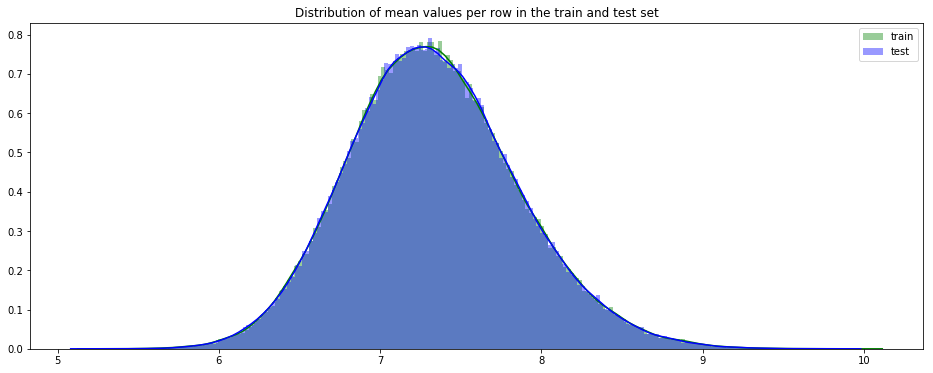

In [30]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=200, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=200, label='test')
plt.legend()
plt.show()

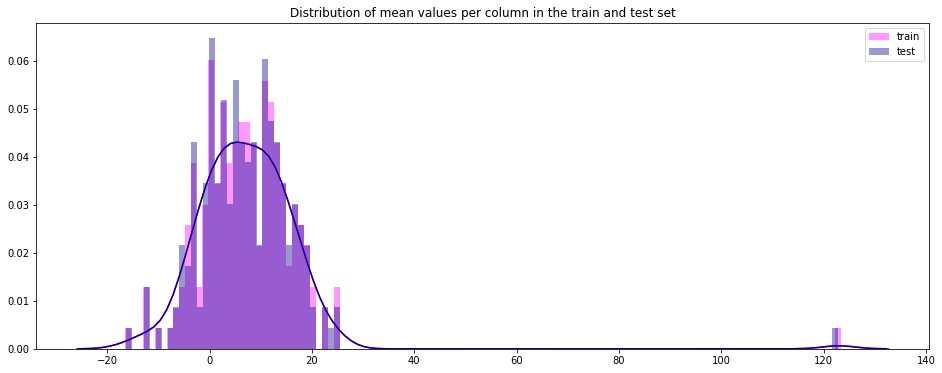

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()


Looks like a few vars have high mean values (these might just be squares of base vars). Let's take a look.

In [44]:
%%time
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

CPU times: user 14.8 s, sys: 16 ms, total: 14.9 s
Wall time: 14.8 s


In [45]:
correlations.tail(10)

,level_0,level_1,0
39790,var_189,var_183,0.009359
39791,var_183,var_189,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_165,var_81,0.009714
39795,var_81,var_165,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_139,var_26,0.009844
39799,var_26,var_139,0.009844


In [46]:
correlations.head(10)

,level_0,level_1,0
0,var_191,var_75,2.703975e-08
1,var_75,var_191,2.703975e-08
2,var_6,var_173,5.942735e-08
3,var_173,var_6,5.942735e-08
4,var_109,var_126,1.313947e-07
5,var_126,var_109,1.313947e-07
6,var_27,var_144,1.772502e-07
7,var_144,var_27,1.772502e-07
8,var_100,var_177,3.116544e-07
9,var_177,var_100,3.116544e-07


In [47]:
%time
features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [48]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,67,107,125,11,90,102,147,70,160,24,124,168,132,42,165
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_133,var_43,var_166
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,6.6803,11.4522,2.7306


In [49]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,67,125,107,11,90,102,147,160,70,24,42,124,165,168,22
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_71,var_25,var_43,var_125,var_166,var_169,var_23
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,0.5389,13.5965,11.5738,12.2189,2.8446,5.8455,2.9221


In [50]:
# %time
# idx = features = train.columns.values[2:202]
# for df in [test, train]:
#     df['sum'] = df[idx].sum(axis=1)  
#     df['min'] = df[idx].min(axis=1)
#     df['max'] = df[idx].max(axis=1)
#     df['mean'] = df[idx].mean(axis=1)
#     df['std'] = df[idx].std(axis=1)
#     df['skew'] = df[idx].skew(axis=1)
#     df['kurt'] = df[idx].kurtosis(axis=1)
#     df['med'] = df[idx].median(axis=1)

In [68]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 1
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
        i += 1
    plt.show();

In [60]:
t1 = train.loc[train['target'] == 1]

In [64]:
t1.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,max,median,std,var,abs_mean,abs_median,abs_std,skew,kurt,sq_kurt
13,1,16.3699,1.5934,16.7395,7.3330,12.1450,5.9004,4.8222,20.9729,1.1064,...,43.2469,6.82455,9.094237,82.705142,8.958531,7.34260,7.100496,0.331609,1.695688,25.099515
29,1,5.3301,-2.6064,13.1913,3.1193,6.6483,-6.5659,5.9064,15.2341,1.2915,...,39.3510,6.69360,9.206875,84.766556,9.162562,7.76155,6.627305,-0.099399,1.109169,19.445059
63,1,7.7072,0.0183,9.9974,8.3524,9.2886,-13.3627,6.0425,10.1108,1.3999,...,29.9410,7.07115,9.358747,87.586145,9.341868,8.97395,6.719750,-0.464280,1.439415,8.434838
65,1,10.5358,-2.5439,8.7394,6.7548,14.4099,-3.8724,5.1584,15.8381,5.8204,...,35.6287,6.56910,9.632892,92.792617,9.225648,8.09835,7.125205,-0.328077,2.278068,11.122792
71,1,6.7547,2.5973,14.2141,8.3514,7.4942,-1.3055,4.2336,15.0243,-1.8922,...,49.6819,7.59360,9.497342,90.199496,9.641468,8.47750,7.426446,0.256815,2.582569,37.809775


In [70]:
# t0 = train.loc[train['target'] == 0]
# t1 = train.loc[train['target'] == 1]
# features = train.columns.values[801:]
# plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

In [27]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
for feature in features:
    train['r2_'+feature] = np.round(train[feature], 2)
    test['r2_'+feature] = np.round(test[feature], 2)
    train['r1_'+feature] = np.round(train[feature], 1)
    test['r1_'+feature] = np.round(test[feature], 1)

In [28]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 625 624


In [83]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [75]:
os.chdir('..')

In [76]:
target = pd.read_csv('testIDs.csv')

In [85]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 12.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=42001)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.881537	valid_1's auc: 0.860686
[2000]	training's auc: 0.908271	valid_1's auc: 0.882408
[3000]	training's auc: 0.920807	valid_1's auc: 0.890908
[4000]	training's auc: 0.928631	valid_1's auc: 0.89474
[5000]	training's auc: 0.934686	valid_1's auc: 0.896938
[6000]	training's auc: 0.940014	valid_1's auc: 0.897873
[7000]	training's auc: 0.944918	valid_1's auc: 0.898353
[8000]	training's auc: 0.949548	valid_1's auc: 0.898537
[9000]	training's auc: 0.953851	valid_1's auc: 0.898569
[10000]	training's auc: 0.957927	valid_1's auc: 0.898663
[11000]	training's auc: 0.961741	valid_1's auc: 0.898596
[12000]	training's auc: 0.965285	valid_1's auc: 0.898616
[13000]	training's auc: 0.968612	valid_1's auc: 0.898651
[14000]	training's auc: 0.971729	valid_1's auc: 0.898535
[15000]	training's auc: 0.974611	valid_1's auc: 0.898239
Early stopping, best iteration is:
[12278]	training's auc: 0.96621	valid_1's auc: 0.

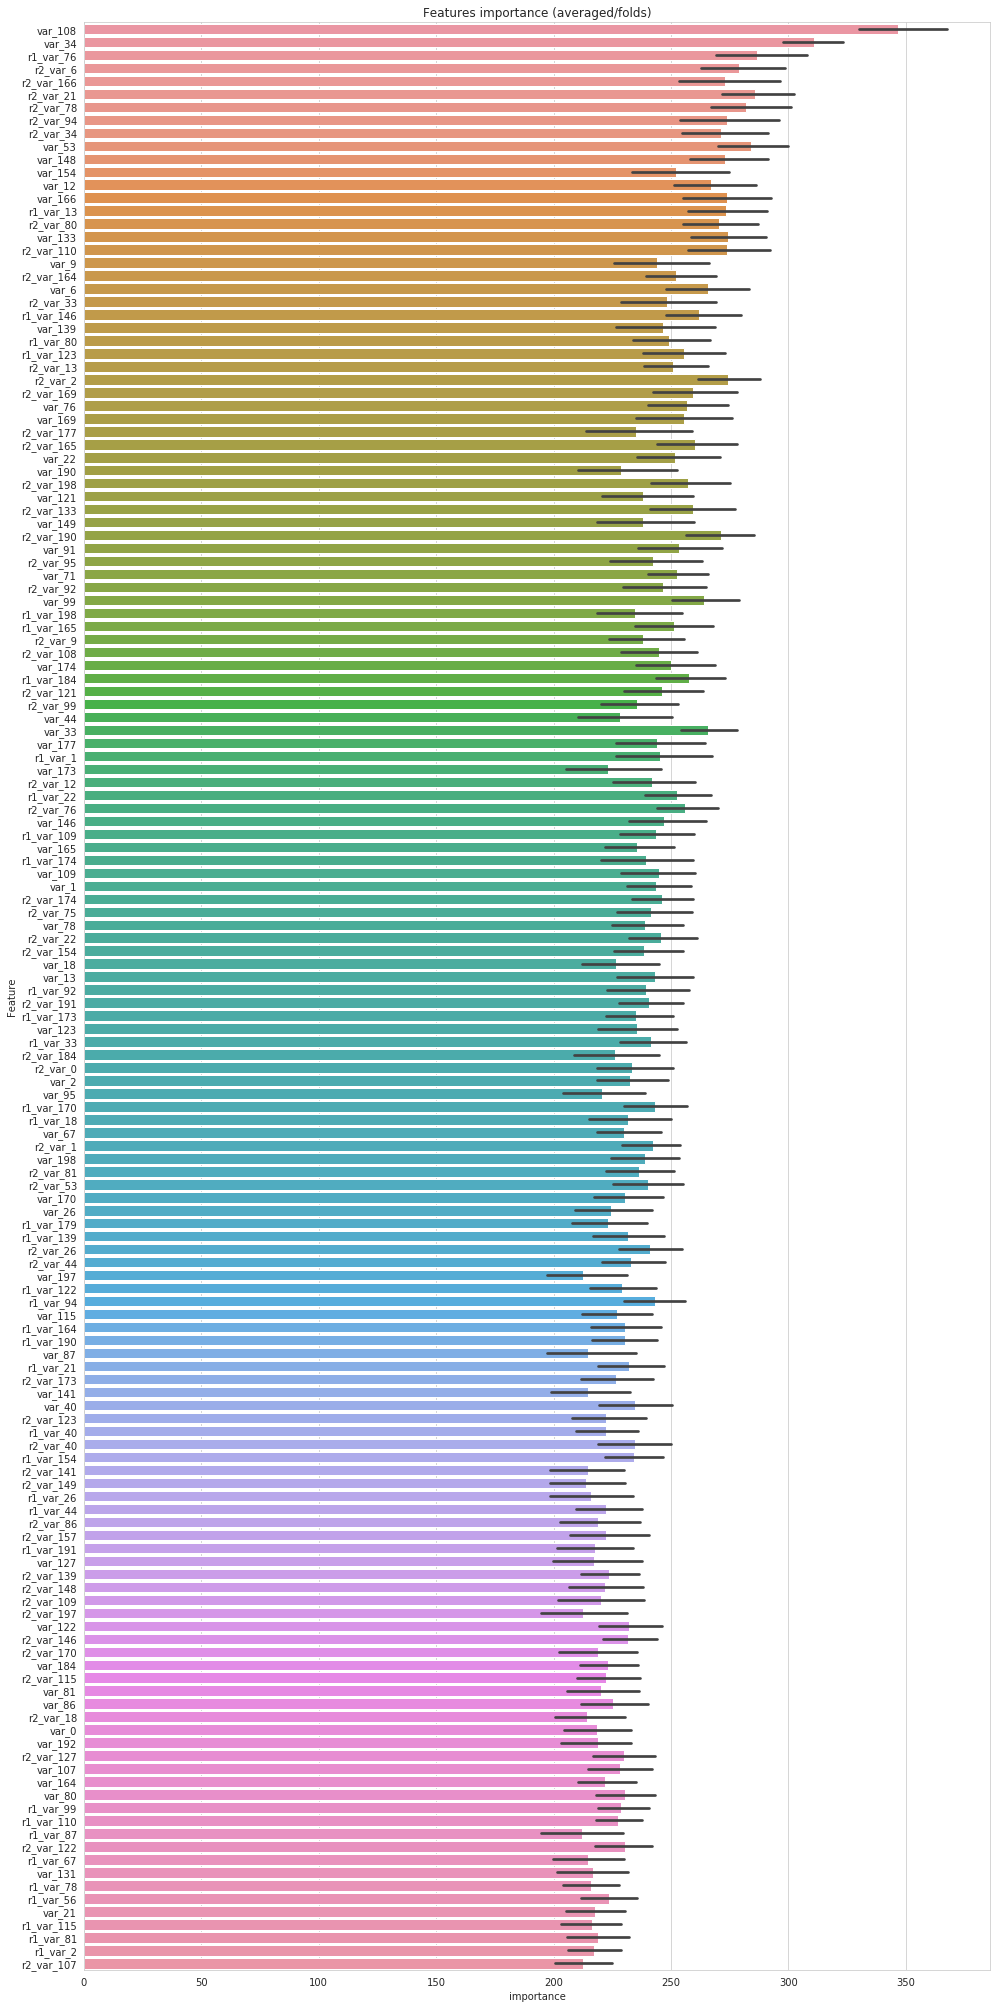

In [57]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [32]:
sub_df = pd.DataFrame({"ID_code":test_IDs.values})
sub_df["target"] = predictions
sub_df.to_csv("sub_xboost_15_fold.csv", index=False)

In [60]:
!ls -lt

total 18492
-rw-r--r-- 1 root root 3116489 Mar  8 20:33 xgboost and other methods.ipynb
-rw-r--r-- 1 root root 6358983 Mar  8 20:31 sub_xboost_2.csv
-rw-r--r-- 1 root root  163046 Mar  8 20:31 FI.png
-rw-r--r-- 1 root root  202415 Mar  8 19:52 xgboost.ipynb
-rw-r--r-- 1 root root   31067 Mar  8 19:52 kaggle_santander_fastai.ipynb
-rw-r--r-- 1 root root 6357092 Mar  8 18:40 sub_xgboost.csv
drwxr-xr-x 2 root root    4096 Mar  8 16:58 models
-rw-r--r-- 1 root root 2688905 Mar  7 22:57 sub_zeros.csv


In [34]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f sub_xboost_15_fold.csv -m "Message"



100%|######################################| 6.07M/6.07M [00:00<00:00, 7.72MB/s]
Successfully submitted to Santander Customer Transaction Prediction

(200000, 624)

## SVM

In [34]:
train.shape

(200000, 202)

In [35]:
test.shape

(200000, 201)

In [38]:
from sklearn.svm import LinearSVC

In [72]:
def normalize(df):
    result = df.copy()
    for feature in features:
        max_val = df[feature].max()
        min_val = df[feature].min()
        result[feature] = (df[feature] - min_val) / (max_val - min_val)
    return result

In [85]:
from sklearn.svm import SVC

In [86]:
clf = SVC(C = 100, kernel='rbf')

In [74]:
train_norm = normalize(features)

In [48]:
features = train.iloc[:,2:]
target = train['target']

In [53]:
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_val, y_train, y_val = train_test_split(train_norm, target, test_size = 0.2, random_state = 42)

In [ ]:
clf.fit(X_train, y_train)

In [78]:
y_pred = clf.predict(X_val)

In [79]:
from sklearn.metrics import accuracy_score

In [80]:
accuracy_score(y_pred, y_val)

0.31285

In [81]:
test_pred = clf.predict(test.drop('ID_code', axis=1))

In [67]:
sub_df = pd.DataFrame({"ID_code":test.ID_code})
sub_df["target"] = test_pred
sub_df.to_csv("svm_pred_1.csv", index=False)

In [68]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f svm_pred_1.csv -m "Message"


100%|######################################| 2.56M/2.56M [00:00<00:00, 2.88MB/s]
Successfully submitted to Santander Customer Transaction Prediction